# Demo notebook

In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [2]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

## Random test

In [3]:
data, labels = dynamic_generate_positive_gaussian_data(
    dim=3,
    nb_classes=3,
    nb_points_per_class=100,
    seed=42
)
data = batch_norm(data)
data[:5]

array([[0.        , 1.        , 0.01959192],
       [1.        , 0.        , 0.4070175 ],
       [0.        , 0.38090406, 1.        ],
       [0.6965442 , 0.        , 1.        ],
       [0.        , 1.        , 0.99405304]])

In [4]:
choquet = Choquet(X=data[0], mu=generate_capacity(enumerate_permute_unit(data[0])), version='d_choquet', p=1, q=1)
print(choquet.choquet)
# choquet.Choquet_classic(verbose=True)

1.2383614


In [9]:
mu=generate_capacity(enumerate_permute_unit(data[0]))
for i in range(len(mu)):
    print(f"Capaicity of {mu[i].X} is {mu[i].mu}")

Capaicity of [] is 0
Capaicity of [0] is 0.03113408288451136
Capaicity of [2] is 0.36852634372376114
Capaicity of [1] is 0.47320990669155716
Capaicity of [0, 2] is 0.651666825375885
Capaicity of [0, 1] is 0.864358249839637
Capaicity of [2, 1] is 0.9681934279147217
Capaicity of [0, 2, 1] is 1


In [10]:
mu=generate_capacity(enumerate_permute_unit(data[0]))
sim = S1(X=data[0], Y=data[10], mu=mu)
print(sim.score())

0.7061884374808548


In [11]:
for i in range(10): 
    sim = S1(X=data[0], Y=data[i], mu=mu)
    print(sim.score())

0.7679246724344335
0.01099755991357292
0.060231720985470985
0.01552901567186307
0.13043819092898287
0.5362689532977206
0.21414307445224895
0.25542980168568413
0.016676561429270882
0.31346974105353287


In [ ]:
KNN = KNNFuzz(input_dimension=4, mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1)
KNN.train(data, labels)

Leave one out avec k = 1
SimLevel1: 0.32666666666666666
SimLevel2: 0.2633333333333333
SimLevel3: 0.34

Result in 11.7620 seconds.
Leave one out avec k = 2
SimLevel1: 0.33666666666666667
SimLevel2: 0.30333333333333334
SimLevel3: 0.3233333333333333

Result in 11.4434 seconds.
Leave one out avec k = 3
SimLevel1: 0.33
SimLevel2: 0.2633333333333333
SimLevel3: 0.31333333333333335

Result in 11.3526 seconds.
Leave one out avec k = 4
SimLevel1: 0.36333333333333334
SimLevel2: 0.2966666666666667
SimLevel3: 0.32666666666666666

Result in 11.7212 seconds.
Leave one out avec k = 5
SimLevel1: 0.3233333333333333
SimLevel2: 0.29
SimLevel3: 0.3566666666666667

Result in 13.3331 seconds.
Leave one out avec k = 6
SimLevel1: 0.35333333333333333
SimLevel2: 0.2833333333333333
SimLevel3: 0.30666666666666664

Result in 13.3872 seconds.
Leave one out avec k = 7
SimLevel1: 0.3466666666666667
SimLevel2: 0.31333333333333335
SimLevel3: 0.30333333333333334

Result in 13.0603 seconds.
Leave one out avec k = 8
SimLev

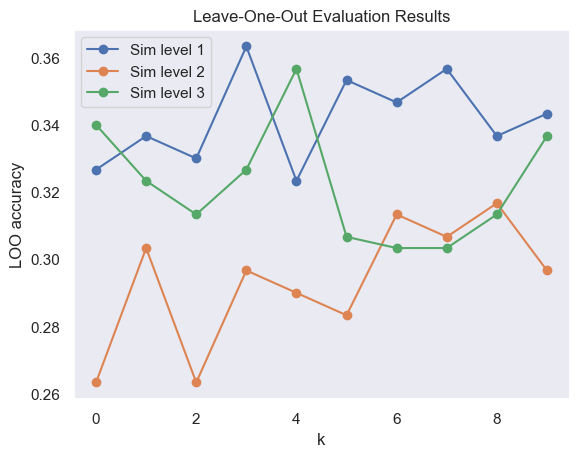

In [13]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute_unit(data[0]))

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data.shape[1],mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data, labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()

## Test on iris

In [9]:
iris = load_iris(as_frame=True)  # returns a dict-like object
df = iris.frame  # get as pandas DataFrame

X = df.drop(columns='target')  # features
y = df['target']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

In [10]:
# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = batch_norm(X)
data_labels = sync_lst_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 150 samples in 4D space.


Leave one out avec k = 1
SimLevel1: 0.6666666666666666
SimLevel2: 0.4066666666666667
SimLevel3: 0.9333333333333333

Result in 4.5911 seconds.
Leave one out avec k = 2
SimLevel1: 0.6666666666666666
SimLevel2: 0.36666666666666664
SimLevel3: 0.92

Result in 4.5478 seconds.
Leave one out avec k = 3
SimLevel1: 0.6666666666666666
SimLevel2: 0.42
SimLevel3: 0.96

Result in 4.5464 seconds.
Leave one out avec k = 4
SimLevel1: 0.6666666666666666
SimLevel2: 0.38
SimLevel3: 0.9533333333333334

Result in 4.5304 seconds.
Leave one out avec k = 5
SimLevel1: 0.6666666666666666
SimLevel2: 0.56
SimLevel3: 0.94

Result in 4.5191 seconds.
Leave one out avec k = 6
SimLevel1: 0.6666666666666666
SimLevel2: 0.5066666666666667
SimLevel3: 0.9666666666666667

Result in 4.6968 seconds.
Leave one out avec k = 7
SimLevel1: 0.6666666666666666
SimLevel2: 0.4533333333333333
SimLevel3: 0.96

Result in 4.7822 seconds.
Leave one out avec k = 8
SimLevel1: 0.6666666666666666
SimLevel2: 0.43333333333333335
SimLevel3: 0.9533

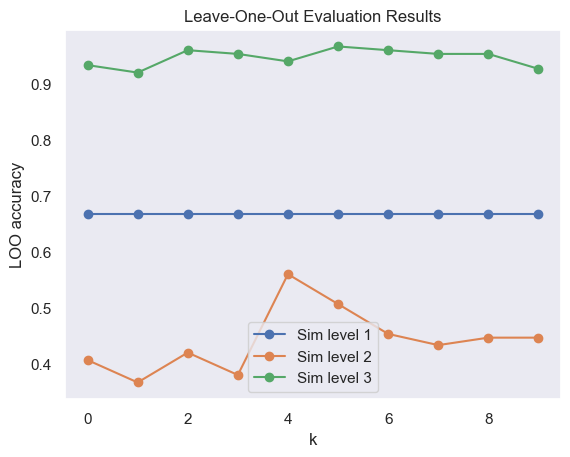

In [11]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute_unit(data_norm[0]))

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data_norm.shape[1], mu=mu, k=3, sim=S1, choquet_version='d_choquet', p=1, q=1), 
            DS = (data_norm, data_labels)
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data_norm.shape[1], mu=mu, k=3, sim=S2, choquet_version='d_choquet', p=1, q=1), 
            DS = (data_norm, data_labels)
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = leave_one_out(
            C = KNNFuzz(input_dimension=data_norm.shape[1], mu=mu, k=k, sim=S3, choquet_version='d_choquet', p=1, q=1), 
            DS = (data_norm, data_labels)
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()

## Test penguins

In [12]:
penguins = load_penguins()
penguins

# Encode
le = LabelEncoder()
le.fit(penguins['island'])
penguins['island'] = le.transform(penguins['island'])

le.fit(penguins['sex'])
penguins['sex'] = le.transform(penguins['sex'])

le.fit(penguins['species'])
penguins['species'] = le.transform(penguins['species'])

# Remove missing values
penguins = penguins.dropna()  # remove rows with missing values
X = penguins.drop(columns='species')  # features
y = penguins['species']  # target

# Turn into array
X = np.array(X)
y = np.array(y)

In [13]:
# Hyperparameters
dim = X.shape[1]  # number of features
nb_classes = len(np.unique(y))  # number of classes

# Normalize data
data_norm = batch_norm(X)
data_labels = sync_lst_to_float_lst(y)
print(f"Normalized data: {data_norm.shape[0]} samples in {data_norm.shape[1]}D space.")

Normalized data: 342 samples in 7D space.


In [14]:
# # LOO evaluation
# # Define list for each sim level
# l1 = []
# l2 = []
# l3 = []
# k = 10

# for k in range(1, k+1): 
#     tic = time.time()
#     mu = generate_capacity(enumerate_permute_unit(data_norm[0]))

#     print(f"Leave one out avec k = {k}")
    
#     # SimLevel1
#     res = leave_one_out(
#             C = KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=S1), 
#             DS = (data_norm, data_labels)
#         )
#     l1.append(res)
#     print(f"SimLevel1: {res}")
#     # Sim level 2
#     res = leave_one_out(
#             C = KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=S2), 
#             DS = (data_norm, data_labels)
#         )
#     l2.append(res)
#     print(f"SimLevel2: {res}")

#     # Sim level 3
#     res = leave_one_out(
#             C = KNNFuzz(input_dimension=data_norm.shape[1],mu=mu, k=k, sim=S3), 
#             DS = (data_norm, data_labels)
#         )
#     l3.append(res)
#     print(f"SimLevel3: {res}")

#     toc = time.time()
#     print(f"Result in {(toc-tic):0.4f} seconds.\n")

# # Plot results
# plt.plot(l1, label="Sim level 1", marker='o')
# plt.plot(l2, label="Sim level 2", marker='o')
# plt.plot(l3, label="Sim level 3", marker='o')

# # Config additional params
# plt.ylabel("LOO accuracy")
# plt.xlabel("k")
# plt.title("Leave-One-Out Evaluation Results")
# plt.grid()
# plt.legend()

In [15]:
restricted_dissim(1, 0.2, p=1, q=2)  # Should return 1

np.float64(0.8944271909999159)

In [16]:
for i in range(20):
    print(d_Choquet_integral(X=data[i], mu=mu))

0.5122874
0.6082897
1.183232
0.33874217
1.433209
1.1653045
0.9673966
0.85961044
0.8349121
1.447497
0.526643
0.33692893
0.8491338
1.506527
0.8525515
0.9925179
1.372129
0.3458757
1.223994
0.39420214


In [18]:
d_Choquet_integral(X=data[0], mu=mu)

array(0.5122874, dtype=float32)

In [23]:
mu

In [64]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

class FuzzyMuEnv(gym.Env):
    def __init__(self, X, y, capacity_list, k=3, sim=None, p=1, q=1, choquet_version="d_choquet", max_steps=100):
        super().__init__()

        self.X = X
        self.y = y
        self.capacity_list = capacity_list  # Pre-generated list of Capacity objects
        self.k = k
        self.sim = sim
        self.p = p
        self.q = q
        self.choquet_version = choquet_version
        self.max_steps = max_steps
        self.current_step = 0

        # Action space: select one capacity from the list
        self.action_space = spaces.Discrete(len(capacity_list))
        
        # Observation space: current step, best reward so far, and some capacity info
        # You can modify this based on what information you want the agent to see
        obs_dim = 3  # [current_step_normalized, best_reward_normalized, random_seed]
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(obs_dim,), dtype=np.float32)

        self.best_reward = -np.inf
        self.best_capacity_idx = None
        self.best_capacity = None
        self.reward_history = []

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.best_reward = -np.inf
        self.best_capacity_idx = None
        self.best_capacity = None
        self.reward_history = []
        
        obs = self._get_observation()
        info = {}
        return obs, info

    
    # Fix 1: Remove random noise from observation
    def _get_observation(self):
        # Normalize current step
        step_norm = self.current_step / self.max_steps
        
        # Normalize best reward
        reward_norm = max(-1.0, min(1.0, self.best_reward)) if self.best_reward != -np.inf else -1.0
        
        # Remove random exploration_factor - replace with deterministic info
        capacity_progress = len(self.reward_history) / len(self.capacity_list) if len(self.capacity_list) > 0 else 0.0
        
        obs = np.array([step_norm, reward_norm, capacity_progress], dtype=np.float32)
        return obs

    def step(self, action):
        # action is an index into the capacity_list
        if not (0 <= action < len(self.capacity_list)):
            raise ValueError(f"Invalid action {action}. Must be between 0 and {len(self.capacity_list)-1}")
        
        selected_capacity = self.capacity_list[action]
        
        try:
            # Use the selected capacity in KNNFuzz
            classifier = KNNFuzz(
                input_dimension=self.X.shape[1],
                mu=selected_capacity,
                k=self.k,
                sim=self.sim,
                choquet_version=self.choquet_version,
                p=self.p,
                q=self.q
            )
            
            reward = leave_one_out(
                C=classifier,
                DS=(self.X, self.y)
            )
            print(f"[INFO] LOO evaluation successful with capacity {action}: {reward}")
            
        except Exception as e:
            print(f"[ERROR] LOO failed with capacity {action}: {e}")
            reward = -1.0  # Penalty for failed evaluation
        
        # Track best performance
        if reward > self.best_reward:
            self.best_reward = reward
            self.best_capacity_idx = action
            self.best_capacity = selected_capacity
        
        self.reward_history.append(reward)
        self.current_step += 1
        
        # Episode termination
        terminated = False
        truncated = self.current_step >= self.max_steps
        
        obs = self._get_observation()
        info = {
            "capacity_index": action,
            "loo_score": reward,
            "best_reward": self.best_reward,
            "best_capacity_idx": self.best_capacity_idx
        }

        return obs, reward, terminated, truncated, info

    def render(self):
        print(f"Step: {self.current_step}/{self.max_steps}")
        print(f"Best reward so far: {self.best_reward}")
        print(f"Best capacity index: {self.best_capacity_idx}")
        if len(self.reward_history) > 0:
            print(f"Recent rewards: {self.reward_history[-5:]}")


# Example usage (you'll need to replace these with your actual functions and data)
def create_example_environment():
    """
    Example of how to create and use the environment.
    Replace this with your actual data and capacity generation logic.
    """
    
    # Replace these with your actual data
    # X = data_norm
    # y = data_labels
    # sim = S1
    
    # Generate your capacity list
    # This is just an example - replace with your actual capacity generation
    # capacity_list = []
    # for i in range(50):  # Generate 50 different capacities
    #     mu = generate_capacity(enumerate_permute_unit(data_norm[0]))
    #     capacity_list.append(mu)
    
    # Create environment
    # env = FuzzyMuEnv(X, y, capacity_list, k=3, sim=sim)
    
    # Optional: sanity check
    # check_env(env, warn=True)
    
    # Train the model
    # model = PPO("MlpPolicy", env, verbose=1)
    # model.learn(total_timesteps=10000)
    
    # Get the best capacity
    # env.render()
    # best_capacity = env.best_capacity
    # best_capacity_idx = env.best_capacity_idx
    
    # return env, model, best_capacity, best_capacity_idx
    pass


# If you want to test a single capacity evaluation:
def test_single_capacity(X, y, capacity, k=3, sim=None, choquet_version="d_choquet", p=1, q=1):
    """
    Test a single capacity to make sure the LOO evaluation works
    """
    try:
        classifier = KNNFuzz(
            input_dimension=X.shape[1],
            mu=capacity,
            k=k,
            sim=sim,
            choquet_version=choquet_version,
            p=p,
            q=q
        )
        
        score = leave_one_out(
            C=classifier,
            DS=(X, y)
        )
        
        print(f"LOO Score: {score}")
        return score
        
    except Exception as e:
        print(f"Error: {e}")
        return None

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback

# Custom callback to track training progress
class PlotCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(PlotCallback, self).__init__(verbose)
        self.rewards = []
        self.best_rewards = []
        self.episodes = []
        self.episode_count = 0
        
    def _on_step(self) -> bool:
        # Get info from the environment
        if 'episode' in self.locals.get('infos', [{}])[0]:
            info = self.locals['infos'][0]
            if 'loo_score' in info:
                self.rewards.append(info['loo_score'])
                self.best_rewards.append(info['best_reward'])
                self.episodes.append(self.episode_count)
                self.episode_count += 1
        return True

# Main training loop example
def train_fuzzy_mu_optimizer(X, y, capacity_list, sim, k=3):
    """
    Main function to train the RL agent to find the best capacity
    """
    
    # Create environment
    env = FuzzyMuEnv(X, y, capacity_list, k=k, sim=sim, max_steps=len(capacity_list))
    
    # Check environment
    check_env(env, warn=True)

    plot_callback = PlotCallback()
    
    # Create and train model
    model = PPO(
        "MlpPolicy", 
        env, 
        verbose=1,
        learning_rate=3e-4,
        n_steps=100,      # default is 2048, but we use smaller steps for faster training
        batch_size=64,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        clip_range=0.2,
        ent_coef=0.01
    )
    
    print("Starting training...")
    model.learn(total_timesteps=300, callback=plot_callback)     # was 50000

    # Evaluate final performance
    print("\nTraining completed!")
    env.render()
    
    return env, model, env.best_capacity, env.best_capacity_idx


# Example of how to use your specific data structure:
# Your usage would look like this:

# 1. Prepare your data
X = data
y = labels
sim = S1

# 2. Generate list of capacities to test
capacity_list = []
for i in range(50):  # Changed from 10 to 50
    mu = generate_capacity(enumerate_permute_unit(data[0]))
    capacity_list.append(mu)
print(f"Generated {len(capacity_list)} capacities.")
print(f"Environment max_steps: {len(capacity_list)}")
print("Starting training...")

# 3. Train the RL agent
env, model, best_capacity, best_idx = train_fuzzy_mu_optimizer(X, y, capacity_list, sim, k=3)
print("Training completed.")

# 4. Use the best capacity
print(f"Best capacity found at index: {best_idx}")
print(f"Best performance: {env.best_reward}")

# 5. You can also test the trained model
obs, _ = env.reset()
for _ in range(10):
    action, _ = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Action: {action}, Reward: {reward}")
    if terminated or truncated:
        obs, _ = env.reset()

Generated 50 capacities.
Environment max_steps: 50
Starting training...
[INFO] LOO evaluation successful with capacity 13: 0.31666666666666665
[INFO] LOO evaluation successful with capacity 4: 0.33
[INFO] LOO evaluation successful with capacity 8: 0.29333333333333333
[INFO] LOO evaluation successful with capacity 10: 0.37
[INFO] LOO evaluation successful with capacity 31: 0.31666666666666665
[INFO] LOO evaluation successful with capacity 16: 0.30666666666666664
[INFO] LOO evaluation successful with capacity 7: 0.2966666666666667
[INFO] LOO evaluation successful with capacity 9: 0.30333333333333334
[INFO] LOO evaluation successful with capacity 1: 0.3566666666666667
[INFO] LOO evaluation successful with capacity 13: 0.31666666666666665
[INFO] LOO evaluation successful with capacity 34: 0.35
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Starting training...
[INFO] LOO evaluation successful with capacity 25: 0.33
[INFO] LOO evaluation succes

/var/folders/p4/7wm8j7tn0n316fy23dlvdbq40000gn/T/ipykernel_55292/3258688756.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


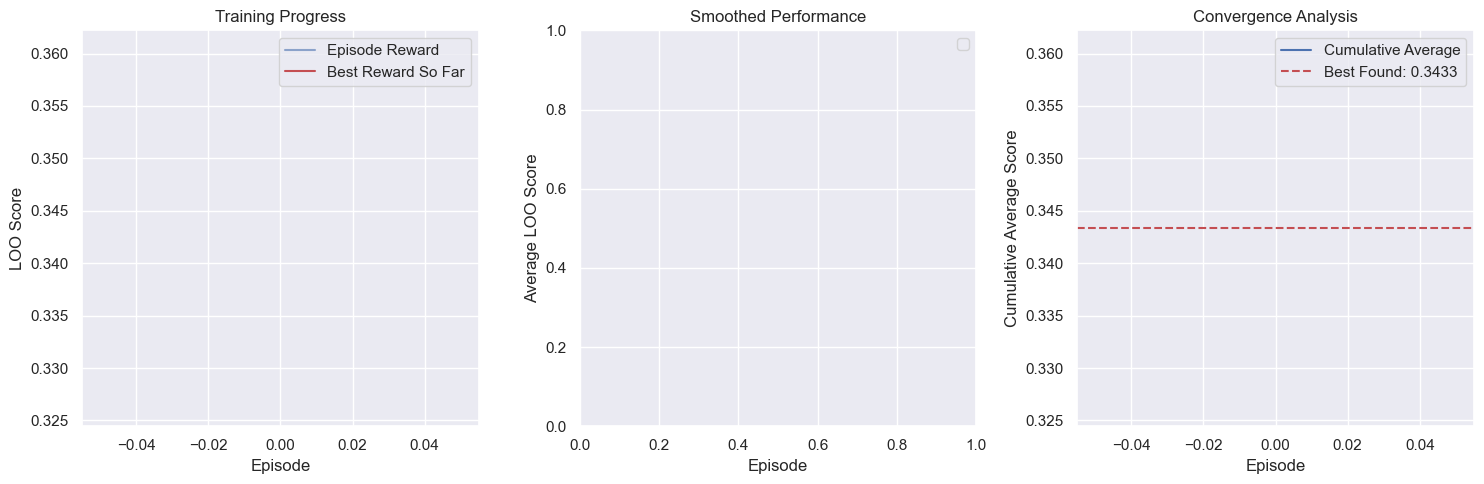


Training Statistics:
Total episodes: 1
Best reward: 0.3433
Final 10 episodes average: 0.3433
Overall average: 0.3433


In [ ]:
# import matplotlib.pyplot as plt
# from stable_baselines3.common.callbacks import BaseCallback

# # Custom callback to track training progress
# class PlotCallback(BaseCallback):
#     def __init__(self, verbose=0):
#         super(PlotCallback, self).__init__(verbose)
#         self.rewards = []
#         self.best_rewards = []
#         self.episodes = []
#         self.episode_count = 0
        
#     def _on_step(self) -> bool:
#         # Get info from the environment
#         if 'episode' in self.locals.get('infos', [{}])[0]:
#             info = self.locals['infos'][0]
#             if 'loo_score' in info:
#                 self.rewards.append(info['loo_score'])
#                 self.best_rewards.append(info['best_reward'])
#                 self.episodes.append(self.episode_count)
#                 self.episode_count += 1
#         return True

# # Add this when creating your model:
# plot_callback = PlotCallback()

# # Modify your model.learn() call:
# model.learn(total_timesteps=10, callback=plot_callback)

# After training, plot the results:
plt.figure(figsize=(15, 5))

# Plot 1: Reward per episode
plt.subplot(1, 3, 1)
plt.plot(plot_callback.episodes, plot_callback.rewards, alpha=0.6, label='Episode Reward')
plt.plot(plot_callback.episodes, plot_callback.best_rewards, 'r-', label='Best Reward So Far')
plt.xlabel('Episode')
plt.ylabel('LOO Score')
plt.title('Training Progress')
plt.legend()
plt.grid(True)

# Plot 2: Moving average of rewards
plt.subplot(1, 3, 2)
window_size = 50
if len(plot_callback.rewards) >= window_size:
    moving_avg = np.convolve(plot_callback.rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(moving_avg, label=f'Moving Average ({window_size} episodes)')
plt.xlabel('Episode')
plt.ylabel('Average LOO Score')
plt.title('Smoothed Performance')
plt.legend()
plt.grid(True)

# Plot 3: Convergence analysis
plt.subplot(1, 3, 3)
plt.plot(np.cumsum(plot_callback.rewards) / np.arange(1, len(plot_callback.rewards) + 1), 
         label='Cumulative Average')
plt.axhline(y=max(plot_callback.best_rewards), color='r', linestyle='--', 
           label=f'Best Found: {max(plot_callback.best_rewards):.4f}')
plt.xlabel('Episode')
plt.ylabel('Cumulative Average Score')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
print(f"\nTraining Statistics:")
print(f"Total episodes: {len(plot_callback.rewards)}")
print(f"Best reward: {max(plot_callback.best_rewards):.4f}")
print(f"Final 10 episodes average: {np.mean(plot_callback.rewards[-10:]):.4f}")
print(f"Overall average: {np.mean(plot_callback.rewards):.4f}")

In [1]:
(8*3 + 17*3 + 14.2*6 + 12*6 + 7.56*6 + 9.125*6) / (3+3+6+6+6+6)

11.077